In [64]:
import requests, zipfile, io


In [65]:
import geopandas as gpd

In [2]:
import pandas as pd
import json
import os
from sqlalchemy import create_engine
import sqlalchemy 
from shapely.geometry import Polygon
import geoalchemy2
from mapbox import Uploader
import sys
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [67]:
sys.path.append('..')

In [68]:
DBname=os.environ['DB_NAME']
postgres_psswd=os.environ['POSTGRES_PASSWORD']
postgres_user=os.environ['POSTGRES_USER']
postgres_port=str(os.environ['POSTGRES_PORT'])
mapbox_api=os.environ['MAPBOX_API_KEY']
mapbox_up=os.environ['MAPBOX_API_UPLOAD_KEY']

In [69]:
# A long string that contains the necessary Postgres login information
postgres_str = ('postgresql://'+postgres_user+':'+postgres_psswd+'@'+DBname+':'+postgres_port+'/superset')
# Create the connection
cnx = create_engine(postgres_str)

In [70]:
#códigos ISO y coordenadas centroides

In [71]:
url='https://raw.githubusercontent.com/DataScienceResearchPeru/covid-19_latinoamerica/master/utils/iso3166-2.csv'

In [72]:
iso=pd.read_csv(url)

In [73]:
name='iso'
schema='geo'
if not cnx.dialect.has_schema(cnx, schema):
    print('schema '+schema+' does not exist, creating it')
    cnx.execute(sqlalchemy.schema.CreateSchema(schema))
else:
    print('schema '+schema+' exists, will not be created')

schema geo exists, will not be created


In [74]:
new_cols=[x.replace('(','').replace(')','') for x in iso.columns]

In [75]:
iso.columns=new_cols

In [76]:
iso

,Country Code,Country Name,Code,Subdivision Name Used,Subdivision Category,Number,Latitude,Longitude,Subdivision Name es,Subdivision Name qu,Subdivision Name ay,Subdivision Name ht,Subdivision Name fr,Parent Subdivision,Local Variant
0,AR,Argentina,AR-B,Buenos Aires,Province,NaN,-37.201729,-59.841070,Buenos Aires,NaN,NaN,NaN,NaN,NaN,NaN
1,AR,Argentina,AR-K,Catamarca,Province,NaN,-28.471588,-65.787721,Catamarca,NaN,NaN,NaN,NaN,NaN,NaN
2,AR,Argentina,AR-H,Chaco,Province,NaN,-27.425718,-59.024378,Chaco,NaN,NaN,NaN,NaN,NaN,NaN
3,AR,Argentina,AR-U,Chubut,Province,NaN,-43.293425,-65.111482,Chubut,NaN,NaN,NaN,NaN,NaN,NaN
4,AR,Argentina,AR-C,Ciudad Autónoma de Buenos Aires,City,NaN,-34.603684,-58.381559,Ciudad Autónoma de Buenos Aires,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404,VE,Venezuela,VE-T,Trujillo,State,NaN,9.430253,-70.526493,Trujillo,NaN,NaN,NaN,NaN,NaN,NaN
405,VE,Venezuela,VE-S,Táchira,State,NaN,7.913700,-72.141613,Táchira,NaN,NaN,NaN,NaN,NaN,NaN
406,VE,Venezuela,VE-X,Vargas,State,NaN,10.589002,-66.736734,Vargas,NaN,NaN,NaN,NaN,NaN,NaN
407,VE,Venezuela,VE-U,Yaracuy,State,NaN,10.340192,-68.745306,Yaracuy,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
iso.to_sql(name, schema=schema,con=cnx,if_exists='replace')

In [131]:
regiones={'RM':"https://opendata.arcgis.com/datasets/a38eda47692e43999559aea6e0d3f7cc_102.geojson",
          'Valparaíso': "https://opendata.arcgis.com/datasets/a38eda47692e43999559aea6e0d3f7cc_101.geojson",
          'Antofagasta': "https://opendata.arcgis.com/datasets/a38eda47692e43999559aea6e0d3f7cc_98.geojson" ,
          'Ñuble': "https://opendata.arcgis.com/datasets/a38eda47692e43999559aea6e0d3f7cc_105.geojson",
          'BíoBío': "https://opendata.arcgis.com/datasets/a38eda47692e43999559aea6e0d3f7cc_106.geojson",
          'Los Ríos': "https://opendata.arcgis.com/datasets/a38eda47692e43999559aea6e0d3f7cc_108.geojson",
          'Aysén': "https://opendata.arcgis.com/datasets/a38eda47692e43999559aea6e0d3f7cc_110.geojson",
       
       'REGIÓN DE ARICA Y PARINACOTA':"https://opendata.arcgis.com/datasets/a38eda47692e43999559aea6e0d3f7cc_96.geojson", 
          'REGIÓN DE COQUIMBO': "https://opendata.arcgis.com/datasets/a38eda47692e43999559aea6e0d3f7cc_100.geojson",
       'REGIÓN DE LA ARAUCANÍA': "https://opendata.arcgis.com/datasets/a38eda47692e43999559aea6e0d3f7cc_107.geojson", 
          'REGIÓN DEL MAULE':'https://opendata.arcgis.com/datasets/a38eda47692e43999559aea6e0d3f7cc_104.geojson', 
          'REGIÓN DE ATACAMA': 'https://opendata.arcgis.com/datasets/a38eda47692e43999559aea6e0d3f7cc_99.geojson',
       'REGIÓN DE LOS LAGOS': 'https://opendata.arcgis.com/datasets/a38eda47692e43999559aea6e0d3f7cc_109.geojson',
       "REGIÓN DEL LIBERTADOR GENERAL BERNARDO O'HIGGINS": 'https://opendata.arcgis.com/datasets/a38eda47692e43999559aea6e0d3f7cc_103.geojson',
       'REGIÓN DE TARAPACÁ': 'https://opendata.arcgis.com/datasets/a38eda47692e43999559aea6e0d3f7cc_97.geojson',
       'REGIÓN DE MAGALLANES Y DE LA ANTÁRTICA CHILENA': 'https://opendata.arcgis.com/datasets/a38eda47692e43999559aea6e0d3f7cc_111.geojson'
       
       }

In [248]:
idx=0
for region in regiones:
    print(idx)
    print('consultando datos de: '+region)
    URL=regiones[region]
    if idx==0:
        zonas=gpd.read_file(URL)
    else:
        zonas=zonas.append(gpd.read_file(URL))
    idx+=1
zonas=zonas.dropna(subset=['geometry'])
zonas['GEOCODIGO']=zonas['GEOCODIGO'].astype(str).str.strip()

0
consultando datos de: RM
1
consultando datos de: Valparaíso
2
consultando datos de: Antofagasta
3
consultando datos de: Ñuble
4
consultando datos de: BíoBío
5
consultando datos de: Los Ríos
6
consultando datos de: Aysén
7
consultando datos de: REGIÓN DE ARICA Y PARINACOTA
8
consultando datos de: REGIÓN DE COQUIMBO
9
consultando datos de: REGIÓN DE LA ARAUCANÍA
10
consultando datos de: REGIÓN DEL MAULE
11
consultando datos de: REGIÓN DE ATACAMA
12
consultando datos de: REGIÓN DE LOS LAGOS
13
consultando datos de: REGIÓN DEL LIBERTADOR GENERAL BERNARDO O'HIGGINS
14
consultando datos de: REGIÓN DE TARAPACÁ
15
consultando datos de: REGIÓN DE MAGALLANES Y DE LA ANTÁRTICA CHILENA


<AxesSubplot:>

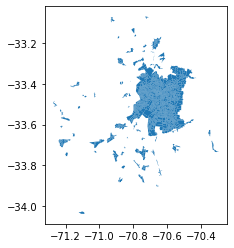

In [249]:
zonas[zonas['REGION'].astype(str)=='13'].plot()

In [250]:
#DESCOMENTAR PARA INSTALAR POSTGIS!!
#cnx.execute('CREATE EXTENSION postgis;')
#cnx.execute('CREATE EXTENSION postgis_topology;')

In [166]:
url='https://opendata.arcgis.com/datasets/54e0c40680054efaabeb9d53b09e1e7a_0.geojson'
manzanas=gpd.read_file(url)

In [266]:
manzanas['GEOCODIGO']=manzanas['MANZENT'].astype(int).astype(str).str[:-3]

In [269]:
manzanas[['TOTAL_PERSONAS','PERSONAS_0_A_5_AÑOS', 'PERSONAS_6_A_14_AÑOS', 'PERSONAS_15_A_64_AÑOS',
       'PERSONAS_MAS_65_AÑOS','ZONA_CENSAL']]=pd.to_numeric(manzanas[['TOTAL_PERSONAS','PERSONAS_0_A_5_AÑOS', 'PERSONAS_6_A_14_AÑOS', 'PERSONAS_15_A_64_AÑOS',
       'PERSONAS_MAS_65_AÑOS','ZONA_CENSAL']].stack(), errors='coerce').unstack()

In [270]:
pop=manzanas.groupby('GEOCODIGO')[['TOTAL_PERSONAS','PERSONAS_0_A_5_AÑOS', 'PERSONAS_6_A_14_AÑOS', 'PERSONAS_15_A_64_AÑOS',
       'PERSONAS_MAS_65_AÑOS']].sum()
pop=pop.astype(int).reset_index()
pop['GEOCODIGO']=pop['GEOCODIGO'].astype(str).str.strip()

In [272]:
zonas=zonas.merge(pop,on='GEOCODIGO',how='left')

In [274]:
zonas.to_postgis(name='zonas_censales', schema=schema,con=cnx,if_exists='replace')

In [275]:
zonas

,OBJECTID,REGION,NOM_REGION,PROVINCIA,NOM_PROVINCIA,COMUNA,NOM_COMUNA,URBANO,COD_DISTRITO,COD_ZONA,GEOCODIGO,Shape_Length,Shape_Area,geometry,TOTAL_PERSONAS,PERSONAS_0_A_5_AÑOS,PERSONAS_6_A_14_AÑOS,PERSONAS_15_A_64_AÑOS,PERSONAS_MAS_65_AÑOS
0,1,13,REGIÓN METROPOLITANA DE SANTIAGO,134,MAIPO,13404,PAINE,PAINE,1,3,13404011003,0.03060,0.00004,"POLYGON ((-70.72732 -33.80301, -70.72803 -33.8...",5608.00000,430.00000,918.00000,3776.00000,214.00000
1,2,13,REGIÓN METROPOLITANA DE SANTIAGO,134,MAIPO,13404,PAINE,PAINE,1,2,13404011002,0.04528,0.00007,"POLYGON ((-70.70792 -33.80101, -70.70805 -33.8...",2435.00000,165.00000,238.00000,1697.00000,292.00000
2,3,13,REGIÓN METROPOLITANA DE SANTIAGO,134,MAIPO,13404,PAINE,PAINE,6,4,13404061004,0.08471,0.00010,"POLYGON ((-70.70724 -33.80454, -70.70726 -33.8...",4074.00000,239.00000,429.00000,2869.00000,396.00000
3,4,13,REGIÓN METROPOLITANA DE SANTIAGO,134,MAIPO,13404,PAINE,PAINE,6,1,13404061001,0.05274,0.00011,"POLYGON ((-70.74243 -33.81015, -70.74229 -33.8...",4014.00000,299.00000,519.00000,2747.00000,403.00000
4,5,13,REGIÓN METROPOLITANA DE SANTIAGO,134,MAIPO,13404,PAINE,PAINE,6,2,13404061002,0.02427,0.00003,"POLYGON ((-70.73996 -33.80852, -70.73996 -33.8...",3738.00000,221.00000,309.00000,2572.00000,437.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4860,50,12,REGIÓN DE MAGALLANES Y DE LA ANTÁRTICA CHILENA,121,MAGALLANES,12101,PUNTA ARENAS,PUNTA ARENAS,7,6,12101071006,0.08591,0.00039,"POLYGON ((-70.93557 -53.20309, -70.93549 -53.2...",3159.00000,280.00000,459.00000,2134.00000,95.00000
4861,51,12,REGIÓN DE MAGALLANES Y DE LA ANTÁRTICA CHILENA,121,MAGALLANES,12101,PUNTA ARENAS,PUNTA ARENAS,10,1,12101101001,0.07126,0.00004,"POLYGON ((-70.93740 -53.23148, -70.93743 -53.2...",205.00000,13.00000,25.00000,128.00000,39.00000
4862,52,12,REGIÓN DE MAGALLANES Y DE LA ANTÁRTICA CHILENA,121,MAGALLANES,12101,PUNTA ARENAS,PUNTA ARENAS,10,4,12101101004,0.15777,0.00053,"POLYGON ((-70.94820 -53.14980, -70.94825 -53.1...",5280.00000,342.00000,659.00000,3847.00000,161.00000
4863,53,12,REGIÓN DE MAGALLANES Y DE LA ANTÁRTICA CHILENA,121,MAGALLANES,12101,PUNTA ARENAS,PUNTA ARENAS,10,3,12101101003,0.04919,0.00007,"POLYGON ((-70.91382 -53.12629, -70.91389 -53.1...",3937.00000,167.00000,456.00000,2880.00000,124.00000


In [14]:
#comunas
#url='https://www.bcn.cl/obtienearchivo?id=repositorio/10221/10396/2/Comunas.zip'
#r = requests.get(url)
#z = zipfile.ZipFile(io.BytesIO(r.content))
#z.extractall("/data/ETLcache/comunas_shp")

In [15]:
#provincias
#url='https://www.bcn.cl/obtienearchivo?id=repositorio/10221/10397/2/Provincias.zip'
#r = requests.get(url)
#z = zipfile.ZipFile(io.BytesIO(r.content))
#z.extractall("/data/ETLcache/provincias_shp")

In [16]:
#regiones
#url='https://www.bcn.cl/obtienearchivo?id=repositorio/10221/10398/2/Regiones.zip'
#r = requests.get(url)
#z = zipfile.ZipFile(io.BytesIO(r.content))
#z.extractall("/data/ETLcache/regiones_shp")

In [17]:
#url='https://raw.githubusercontent.com/ivanMSC/COVID19_Chile/master/utils/Mapa%20de%20Chile%20con%20Zoom%20en%20Santiago.json'
#response = requests.get(url)
#data = response.json()

In [18]:
#data

In [19]:
#url='https://gist.githubusercontent.com/rhernandog/7d055482f5cc803852a762de873bea62/raw/2bed9aed94ab644533b5e624a4e8f165a4650d48/regiones-provincias-comunas.json'
#response = requests.get(url)
#data = response.json()

In [20]:
#gdf = gpd.GeoDataFrame(data)

In [21]:
#from mapbox import Uploader

In [22]:
#conxn = Uploader(access_token='')

In [23]:
#resp = conxn.upload('RGB.byte.tif', 'RGB-byte-tif')

In [3]:
os.system('jupyter nbconvert --output /home/jovyan/work/ETLdocs/' + 'ETL_geo.html' + ' --to html ' + 
          '/home/jovyan/work/ETL/geo.ipynb')

0